In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações para melhorar a aparência dos gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

In [2]:
def parse_timing_file(filepath):
    """
    Analisa um arquivo de tempos (stderr) para extrair as métricas de tempo.
    Retorna um dicionário com os tempos em microssegundos.
    """
    times = {}
    if not os.path.exists(filepath):
        print(f"Arquivo não encontrado: {filepath}")
        return None
        
    with open(filepath, 'r') as f:
        for line in f:
            # Ex: TEMPO_LEITURA_ARQUIVO_US: 123456
            match = re.match(r'(TEMPO_[A-Z_]+_US): (\d+)', line)
            if match:
                key = match.group(1).replace('_US', '') # Ex: TEMPO_LEITURA_ARQUIVO
                value = int(match.group(2))
                times[key] = value
    return times

def extract_params_from_filename(filename):
    """
    Extrai parâmetros (num_pacotes, num_clientes, num_queries_total) do nome do arquivo.
    Assume o formato: tempos_pX_cY_qZ.txt
    Você pode ajustar esta regex se seu padrão de nome for diferente.
    """
    # Ex: tempos_p1000_c100_q100.txt
    match = re.match(r'tempos_p(\d+)_c(\d+)_q(\d+)\.txt', filename)
    if match:
        return {
            'num_pacotes_eventos': int(match.group(1)),
            'num_clientes_no_input': int(match.group(2)), # Este é o numclients do genwkl3.c
            'num_queries_no_input': int(match.group(3)) # Este é a soma de numcl + numpc
        }
    return {}

def analyze_all_timings(timings_dir="."):
    """
    Coleta e analisa todos os arquivos de tempo em um diretório.
    Retorna um DataFrame do Pandas com os dados.
    """
    data = []
    print(f"DEBUG: Procurando arquivos de tempo em: {os.path.abspath(timings_dir)}")
    
    found_any_timing_file_pattern = False # Flag para saber se achou algum arquivo que começa com "tempos_"
    
    # Lista todos os arquivos e diretórios no caminho especificado
    try:
        dir_contents = os.listdir(timings_dir)
    except FileNotFoundError:
        print(f"ERRO: O diretório '{timings_dir}' não foi encontrado.")
        return None

    for filename in dir_contents:
        if filename.startswith("tempos_") and filename.endswith(".txt"):
            found_any_timing_file_pattern = True
            filepath = os.path.join(timings_dir, filename)
            print(f"\nDEBUG: --- Processando arquivo: {filepath} ---") # DEBUG PRINT
            
            timing_data = parse_timing_file(filepath)
            params = extract_params_from_filename(filename) 
            
            print(f"DEBUG:   Dados de tempo parsed: {timing_data}") # DEBUG PRINT
            print(f"DEBUG:   Parâmetros extraídos do nome: {params}") # DEBUG PRINT

            # Verificação dos critérios para adicionar a linha
            add_row = True
            if timing_data is None or not timing_data: # Verifica se os dados de tempo foram lidos corretamente
                print(f"DEBUG:   AVISO: Não foi possível extrair dados de tempo de {filename}. Linha não será adicionada.")
                add_row = False
            if not params: # Verifica se os parâmetros foram extraídos do nome do arquivo
                print(f"DEBUG:   AVISO: Não foi possível extrair parâmetros do nome do arquivo {filename}. Linha não será adicionada.")
                add_row = False
            
            if add_row:
                row = {**params, **timing_data}
                data.append(row)
                print(f"DEBUG:   Linha adicionada ao DataFrame para {filename}.")
            else:
                print(f"DEBUG:   Linha NÃO adicionada ao DataFrame para {filename} devido a problemas na extração.")
    
    if not found_any_timing_file_pattern:
        print(f"DEBUG: NENHUM arquivo que começa com 'tempos_' e termina com '.txt' foi encontrado em '{timings_dir}'.")
        print("DEBUG: Certifique-se de que os arquivos existem e o nome está correto (ex: 'tempos_p100_c10_q20.txt').")

    if not data:
        print(f"DEBUG: AVISO FINAL: Nenhum dado válido foi coletado para o DataFrame, ele estará vazio.")
        return None

    df = pd.DataFrame(data)
    df = df.sort_values(by=['num_pacotes_eventos', 'num_clientes_no_input', 'num_queries_no_input'])
    return df

In [3]:
# Diretório onde seus arquivos de tempo estão salvos.
# Se o notebook está na pasta 'TP3' e os arquivos 'tempos_*.txt' estão diretamente dentro de 'TP3':
timings_directory = "./tempos_resultados/" 

performance_data_df = analyze_all_timings(timings_directory)

if performance_data_df is not None:
    print("Dados de Desempenho Coletados:")
    print(performance_data_df)
else:
    print("Não foi possível coletar dados de desempenho.")
performance_data_df

DEBUG: Procurando arquivos de tempo em: /home/datacaio/ufmg/EstruturaDeDados/TPs/TP3/tempos_resultados

DEBUG: --- Processando arquivo: ./tempos_resultados/tempos_p600_c700_q150.txt ---
DEBUG:   Dados de tempo parsed: {'TEMPO_LEITURA_ARQUIVO': 43737, 'TEMPO_PROCESSAMENTO_EV': 4900, 'TEMPO_CONSULTA_CL': 2005, 'TEMPO_CONSULTA_PC': 7036, 'TEMPO_TOTAL_EXECUCAO': 43773}
DEBUG:   Parâmetros extraídos do nome: {'num_pacotes_eventos': 600, 'num_clientes_no_input': 700, 'num_queries_no_input': 150}
DEBUG:   Linha adicionada ao DataFrame para tempos_p600_c700_q150.txt.

DEBUG: --- Processando arquivo: ./tempos_resultados/tempos_p200_c200_q50.txt ---
DEBUG:   Dados de tempo parsed: {'TEMPO_LEITURA_ARQUIVO': 6679, 'TEMPO_PROCESSAMENTO_EV': 740, 'TEMPO_CONSULTA_CL': 456, 'TEMPO_CONSULTA_PC': 1238, 'TEMPO_TOTAL_EXECUCAO': 6716}
DEBUG:   Parâmetros extraídos do nome: {'num_pacotes_eventos': 200, 'num_clientes_no_input': 200, 'num_queries_no_input': 50}
DEBUG:   Linha adicionada ao DataFrame para temp

,num_pacotes_eventos,num_clientes_no_input,num_queries_no_input,TEMPO_LEITURA_ARQUIVO,TEMPO_PROCESSAMENTO_EV,TEMPO_CONSULTA_CL,TEMPO_CONSULTA_PC,TEMPO_TOTAL_EXECUCAO
1086,50,50,50,2039,166,361,741,2071
2260,50,50,100,2811,157,644,1180,2847
4839,50,50,150,3656,132,846,1901,3689
3266,50,50,200,5569,246,1389,2919,5605
5790,50,50,250,13387832,221,1578,13384987,13387872
...,...,...,...,...,...,...,...,...
4108,950,950,750,216321,10968,22349,115930,216364
3955,950,950,800,252593,11930,32553,138672,252627
5353,950,950,850,224116,11151,24418,121459,224152
6741,950,950,900,203169,11122,25526,98926,203206


In [11]:
def plot_performance_em_grade(df, x_axis_col, title_prefix="Desempenho", 
                              display_plot=True, save_plot=False, save_path="graficos"):
    import matplotlib.ticker as mticker

    if df is None or df.empty or df.shape[0] < 2:
        print(f"DataFrame para análise de '{x_axis_col}' está vazio ou tem poucos dados. Gráfico não gerado.")
        return

    if save_plot:
        os.makedirs(save_path, exist_ok=True)

    time_metrics = [
        "TEMPO_LEITURA_ARQUIVO",
        "TEMPO_PROCESSAMENTO_EV",
        "TEMPO_CONSULTA_CL",
        "TEMPO_CONSULTA_PC",
        "TEMPO_TOTAL_EXECUCAO"
    ]
    
    df_plot = df.copy()
    for metric in time_metrics:
        if metric in df_plot.columns:
            df_plot[metric] = df_plot[metric] / 1_000_000.0

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 11))
    axes_flat = axes.flatten()
    palette = sns.color_palette("Set1")

    for i, metric in enumerate(time_metrics):
        ax = axes_flat[i]
        sns.lineplot(
            data=df_plot, x=x_axis_col, y=metric, marker='o', 
            ax=ax, color=palette[i % len(palette)], linewidth=2.5, markersize=8
        )
        # Título mais legível
        ax.set_title(metric.replace('TEMPO_', '').replace('_', ' ').title(), fontsize=13, fontweight='bold')
        ax.set_xlabel(x_axis_col.replace('_', ' ').title(), fontsize=11)
        ax.set_ylabel("Tempo (s)", fontsize=11)
        ax.grid(True, linestyle=':', alpha=0.7)
        ax.tick_params(axis='both', labelsize=10)
        # Formatação dos valores do eixo y
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.3f}'))
        # Adiciona valores nos pontos (se poucos pontos)
        if len(df_plot[x_axis_col].unique()) <= 10:
            for x, y in zip(df_plot[x_axis_col], df_plot[metric]):
                ax.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,8), ha='center', fontsize=9)

    axes_flat[-1].set_visible(False)
    fig.suptitle(title_prefix, fontsize=20, fontweight='bold', y=1.03)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])

    if save_plot:
        filename = f"grade_vs_{x_axis_col.lower()}.png"
        full_save_path = os.path.join(save_path, filename)
        fig.savefig(full_save_path)
        print(f"Gráfico '{filename}' salvo em '{full_save_path}'")

    if display_plot:
        plt.show()
    plt.close(fig)

Analisando impacto dos clientes com 400 pacotes e 400 queries fixos.


/home/datacaio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/datacaio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/datacaio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/datacaio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

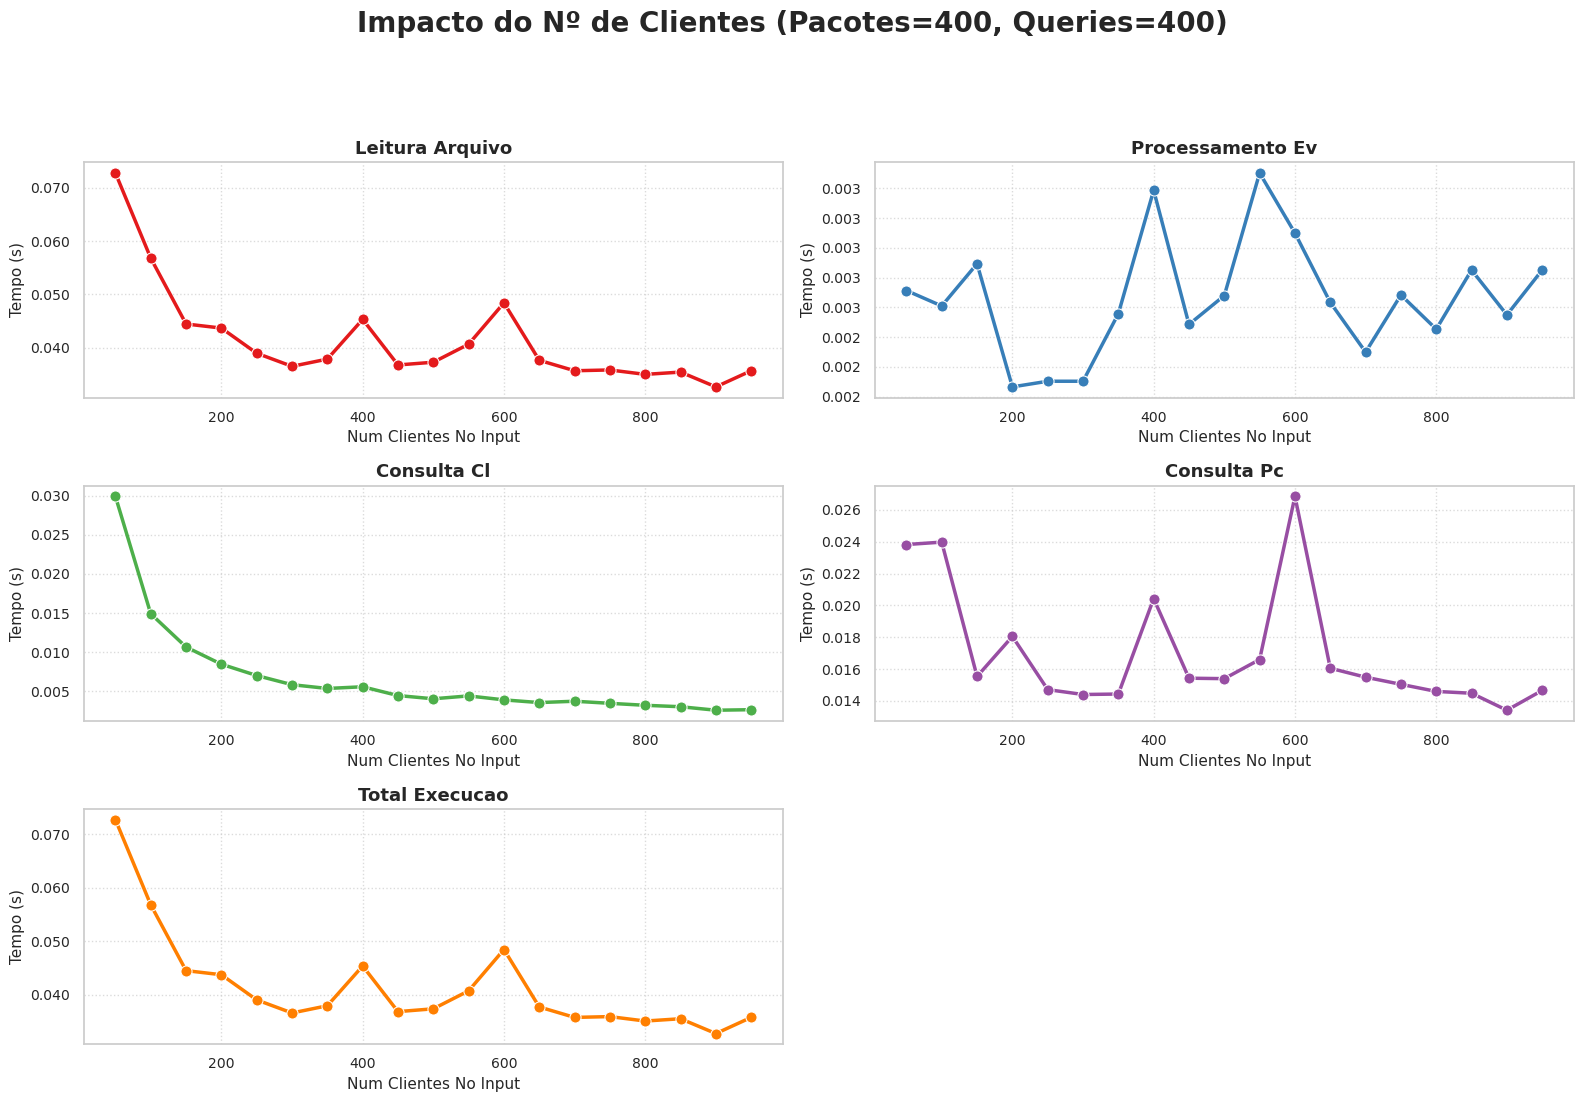

In [12]:
# --- Análise 2: Impacto do Número de Clientes (Em Grade) ---

PACOTES_FIXO = 400
QUERIES_FIXO = 400

df_clientes = performance_data_df[
    (performance_data_df['num_pacotes_eventos'] == PACOTES_FIXO) & 
    (performance_data_df['num_queries_no_input'] == QUERIES_FIXO)
]

print(f"Analisando impacto dos clientes com {PACOTES_FIXO} pacotes e {QUERIES_FIXO} queries fixos.")
plot_performance_em_grade(df_clientes, 
                          x_axis_col='num_clientes_no_input', 
                          title_prefix=f"Impacto do Nº de Clientes (Pacotes={PACOTES_FIXO}, Queries={QUERIES_FIXO})")

Analisando impacto das queries com 400 pacotes e 400 clientes fixos.


/home/datacaio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/datacaio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/datacaio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/datacaio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

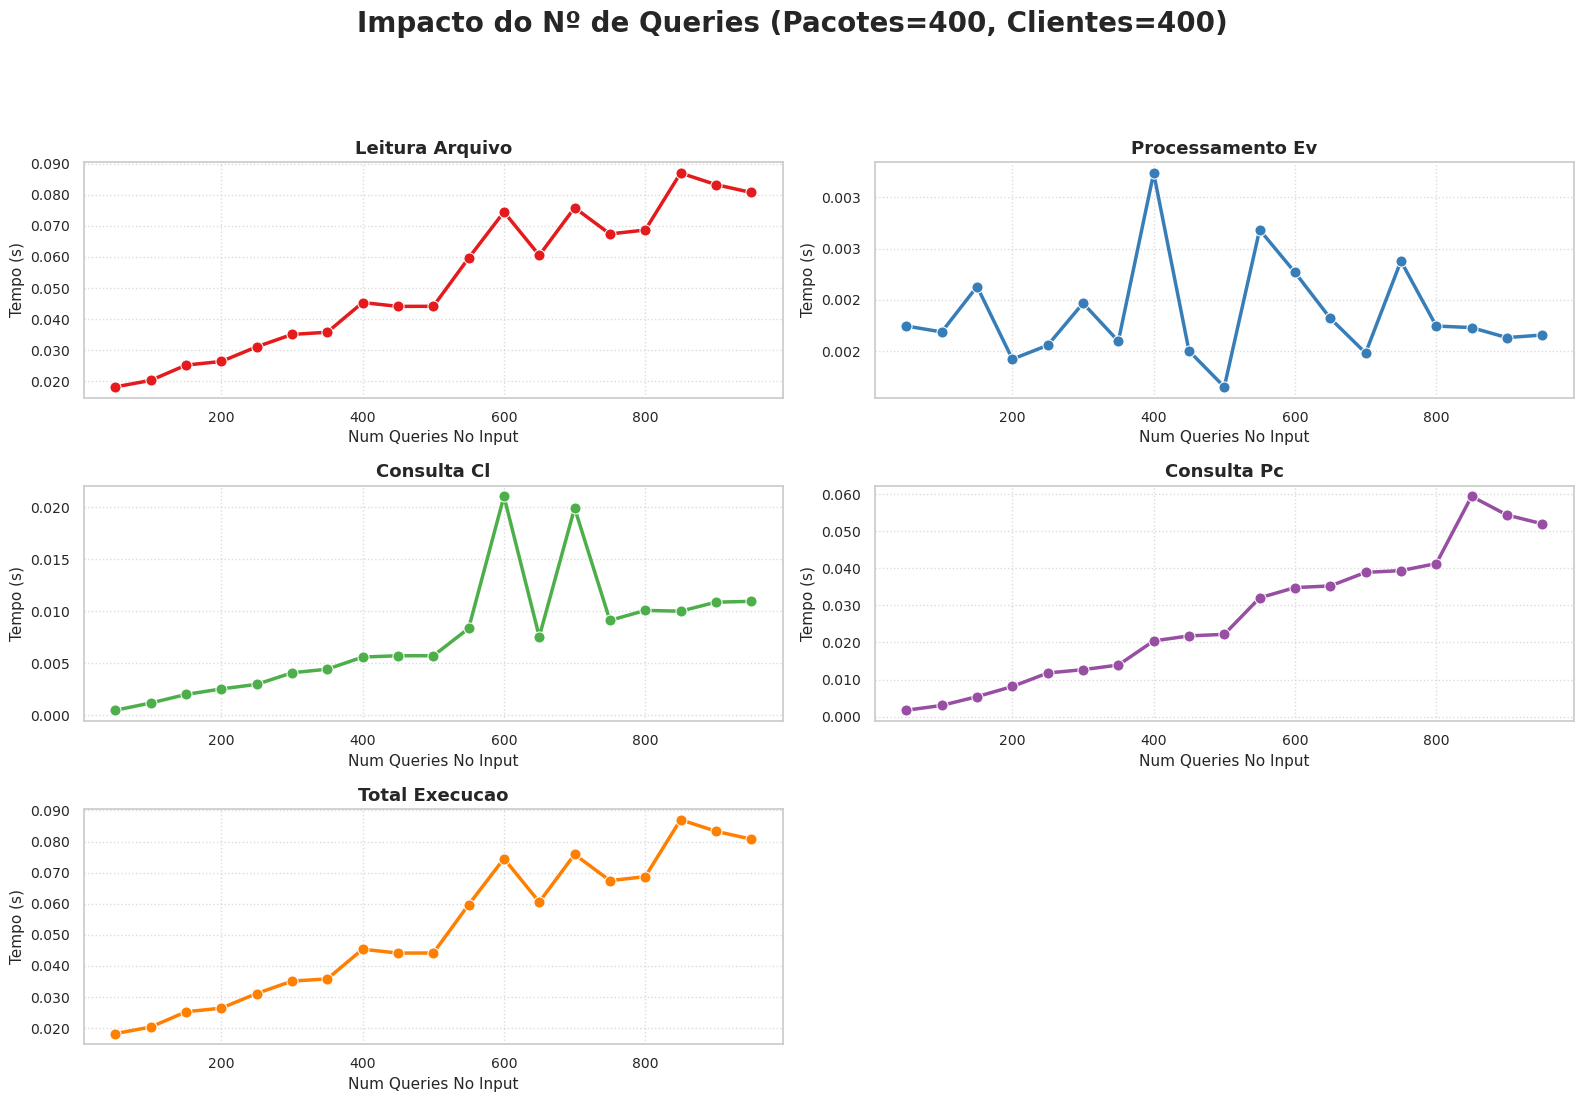

<Figure size 1000x600 with 0 Axes>

In [ ]:
# --- Análise 3: Impacto do Número de Queries (Em Grade) ---

PACOTES_FIXO = 200
CLIENTES_FIXO = 200

df_queries = performance_data_df[
    (performance_data_df['num_pacotes_eventos'] == PACOTES_FIXO) & 
    (performance_data_df['num_clientes_no_input'] == CLIENTES_FIXO)
]

print(f"Analisando impacto das queries com {PACOTES_FIXO} pacotes e {CLIENTES_FIXO} clientes fixos.")
plot_performance_em_grade(df_queries, 
                          x_axis_col='num_queries_no_input', 
                          title_prefix=f"Impacto do Nº de Queries (Pacotes={PACOTES_FIXO}, Clientes={CLIENTES_FIXO})")
for ax in plt.gcf().axes:
    for line in ax.get_lines():
        line.set_color('blue')
plt.show()